In [ ]:
from pathlib import Path
folder = Path('data/images')           # or whichever relative path you expect

print("folder exists? ", folder.exists())
print("files found   : ", list(folder.glob('*'))[:5])      # peek

# show what the current glob picks up
print("jpg/jpeg hits :", list(folder.glob('*.[jJ][pP]*g')))

folder exists?  True
files found   :  [WindowsPath('data/images/20250612-game1.jpg'), WindowsPath('data/images/20250612-game10.jpeg'), WindowsPath('data/images/20250612-game2.jpeg'), WindowsPath('data/images/20250612-game3.jpeg'), WindowsPath('data/images/20250612-game4.jpg')]
jpg/jpeg hits : [WindowsPath('data/images/20250612-game1.jpg'), WindowsPath('data/images/20250612-game10.jpeg'), WindowsPath('data/images/20250612-game2.jpeg'), WindowsPath('data/images/20250612-game3.jpeg'), WindowsPath('data/images/20250612-game4.jpg'), WindowsPath('data/images/20250612-game5.jpg'), WindowsPath('data/images/20250612-game6.jpg'), WindowsPath('data/images/20250612-game7.jpg'), WindowsPath('data/images/20250612-game8.jpg'), WindowsPath('data/images/20250612-game9.jpeg')]


In [ ]:
# 0. imports ----------------------------------------------------
from pathlib import Path
import cv2, numpy as np
from pytesseract import image_to_string

WHITELIST = "123456789X/-F "

# 1. helpers ----------------------------------------------------
def upscale(tile):
    big   = cv2.resize(tile, None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)
    sharp = cv2.GaussianBlur(big, (0,0), 1)
    return cv2.addWeighted(big, 1.25, sharp, -0.25, 128).clip(0,255).astype("uint8")

def to_binary(tile_bgr: np.ndarray) -> np.ndarray:
    hsv  = cv2.cvtColor(tile_bgr, cv2.COLOR_BGR2HSV)
    # keep *bright* pixels irrespective of hue (digits are bright)
    _, v  = cv2.threshold(hsv[...,2], 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return v          # white glyphs, black bg

def ocr_panel(panel_bgr: np.ndarray,
              max_chars: int) -> list[str]:
    """
    Return up to `max_chars` glyphs from left→right inside one frame panel.
    Fill missing slots with '-' so caller can rely on length.
    """
    bin_img = to_binary(upscale(panel_bgr))

    cnts,_ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL,
                              cv2.CHAIN_APPROX_SIMPLE)
    # ignore tiny specks (glare)
    cnts   = [c for c in cnts if cv2.contourArea(c) > 40]

    # sort blobs by x
    blobs = sorted(cnts, key=lambda c: cv2.boundingRect(c)[0])[:max_chars]

    symbols = []
    for c in blobs:
        x,y,w,h = cv2.boundingRect(c)
        char_roi = panel_bgr[y:y+h, x:x+w]
        symbols.append(ocr_symbol(char_roi))

    # pad with '-' if fewer blobs than expected
    while len(symbols) < max_chars:
        symbols.append('-')
    return symbols

def deskew(strip: np.ndarray, max_skew: float = 7.0) -> np.ndarray:
    """
    Detect the dominant orientation of the blue frame block and rotate the
    strip so grid lines become vertical.  Guaranteed final angle ∈ [-max_skew, max_skew].
    """
    # --- 1. isolate the blue panel (loosen S & V thresholds) -------------
    hsv   = cv2.cvtColor(strip, cv2.COLOR_BGR2HSV)
    mask  = cv2.inRange(hsv, (90, 30, 30),   # H, S, V lower bounds
                              (140,255,255)) # upper bounds
    mask  = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,
                             np.ones((5,5), np.uint8), 2)

    # --- 2. biggest blob → min-area rectangle ----------------------------
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return strip                               # nothing blue → skip

    rect   = cv2.minAreaRect(max(cnts, key=cv2.contourArea))
    (_, _), (w, h), angle = rect                   # unpack

    # OpenCV ↔ intuition reconciliation
    # ----------------------------------
    #  rect.angle  is:
    #     *   0 … –45°   when w ≥ h
    #     * –90 … –45°   when w <  h   (newer)  **OR**  +90° / –90° (older builds)
    #
    if w < h:                                     # tall rectangle
        angle += 90                               # bring it into (–45, +45)

    if abs(angle) < 0.5 or abs(angle) > max_skew: # already straight or insane
        return strip

    # --- 3. rotate --------------------------------------------------------
    H, W = strip.shape[:2]
    M    = cv2.getRotationMatrix2D((W/2, H/2), angle, 1.0)
    return cv2.warpAffine(strip, M, (W, H),
                          flags=cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_REPLICATE)


# 2. main pipeline ----------------------------------------------
def read_bowler_row(img):
    H = img.shape[0]
    strip = img[int(0.3*H): int(0.59*H)]   # fixed top / bottom crop
    return deskew(strip)
    # return strip

# ---------------------------------------------------------------
# 3. slice_frames now returns exactly 21 tiles (or dummies)
# ---------------------------------------------------------------
def slice_frames(row: np.ndarray) -> list[str]:
    H, W, _ = row.shape
    w = W // 10

    symbols = []
    for i in range(9):                       # frames 1‥9
        panel = row[:, i*w:(i+1)*w]
        symbols.extend(ocr_panel(panel, max_chars=2))

    # frame 10
    panel10 = row[:, 9*w:]
    symbols.extend(ocr_panel(panel10, max_chars=3))

    # drop trailing blanks & cap at 21
    while symbols and symbols[-1] == '-':
        symbols.pop()
    return symbols[:21]

def ocr_symbol(tile_bgr):
    tile = upscale(tile_bgr)
    gray = cv2.cvtColor(tile, cv2.COLOR_BGR2GRAY)
    _, th = cv2.threshold(gray, 0, 255,
                          cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    txt  = image_to_string(
              th,
              config=f"--oem 3 --psm 10 -c tessedit_char_whitelist={WHITELIST}"
          ).strip()
    return txt or "-"

def extract_bowling_symbols(path: Path) -> list[str]:
    img  = cv2.imread(str(path))
    row  = read_bowler_row(img)
    syms = slice_frames(row)          # ← already the 17–21 glyphs
    # remove trailing blanks added by ocr_panel()
    while syms and syms[-1] == "-":
        syms.pop()
    return syms[:21]

# 3. demo --------------------------------------------------------
print("OCR symbol list:",
      extract_bowling_symbols(Path("data/images/20250421-game2.jpg")))

OCR symbol list: ['4', '-', '-', '-', '72', '-', 'X', '-', '61', '-', '27', '-', '/X', '-', '9', '-', '/X', '-', '36']


In [101]:
row   = read_bowler_row(cv2.imread("data/images/20250421-game2.jpg"))
cv2.imwrite("debug-strip.jpg", row)            # ← should show the ten frames

tiles = slice_frames(row)
for i, t in enumerate(tiles[:21]):
    cv2.imwrite(f"tile_{i}.png", t)            # glyph must be visible


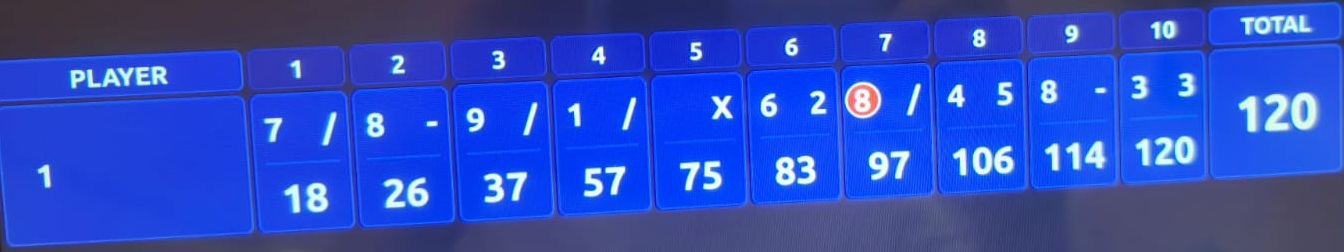

>>> RAW OCR TEXT
 1 2 3 4 5 6 7 9
7-91 x24-33

1 120
4182637 577583 97106114 120


>>> TOKENS  (len = 46 )
 ['1', '2', '3', '4', '5', '6', '7', '9', '7', '-', '9', '1', 'x', '2', '4', '-', '3', '3', '1', '1', '2', '0', '4', '1', '8', '2', '6', '3', '7', '5', '7', '7', '5', '8', '3', '9', '7', '1', '0', '6', '1', '1', '4', '1', '2', '0']


In [16]:
# ------------------------------------------------------------------
# Helper: dump raw OCR text + token list for ONE board  -------------
# ------------------------------------------------------------------
def debug_board(img_path: Path):
    from IPython.display import display
    
    img  = load_and_standardise(img_path)
    display(img)                             # show the screenshot
    raw  = pytesseract.image_to_string(img, config=tess_cfg)
    print(">>> RAW OCR TEXT\n", raw)
    
    tokens = re.findall(r'[0-9Xx/\-]', raw)
    print("\n>>> TOKENS  (len =", len(tokens), ")\n", tokens)

# Call it on any file
debug_board(IMG_DIR / "20250612-game1.jpg")

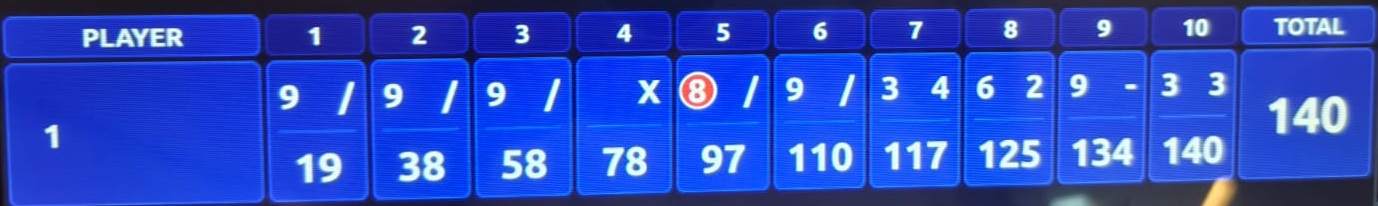

>>> RAW OCR TEXT
 9/9/91 x/9 34162/9-/33 240
1938587897110117125134140


>>> TOKENS  (len = 48 )
 ['9', '/', '9', '/', '9', '1', 'x', '/', '9', '3', '4', '1', '6', '2', '/', '9', '-', '/', '3', '3', '2', '4', '0', '1', '9', '3', '8', '5', '8', '7', '8', '9', '7', '1', '1', '0', '1', '1', '7', '1', '2', '5', '1', '3', '4', '1', '4', '0']


In [18]:
debug_board(IMG_DIR / "20250612-game2.jpeg")

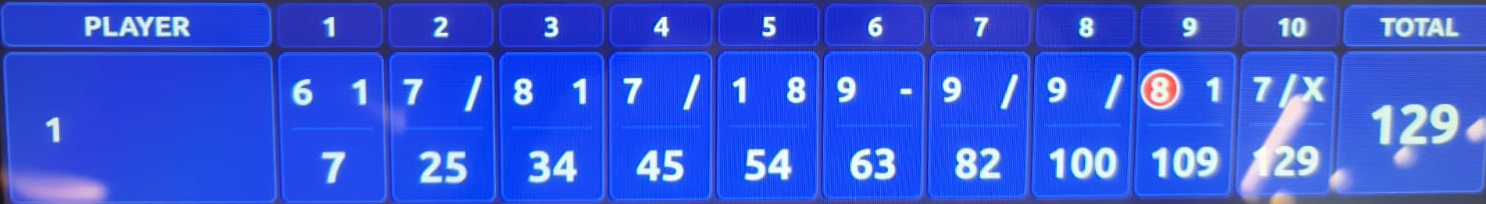

>>> RAW OCR TEXT
 647/7-8
1 129
725344554638210010925


>>> TOKENS  (len = 32 )
 ['6', '4', '7', '/', '7', '-', '8', '1', '1', '2', '9', '7', '2', '5', '3', '4', '4', '5', '5', '4', '6', '3', '8', '2', '1', '0', '0', '1', '0', '9', '2', '5']


In [21]:
debug_board(IMG_DIR / "20250612-game3.jpeg")

### Rotate Image

In [ ]:
import cv2, numpy as np
def find_skew_angle(img_bgr, h_lo=(90,30,30), h_hi=(140,255,255),
                    max_skew=15):
    """
    Return the dominant rotation angle (° CW) of the blue scoreboard strip.
    Positive = clockwise.  If |angle| > max_skew or contour missing → 0.0.
    """
    hsv  = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, h_lo, h_hi)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE,
                            np.ones((5,5),np.uint8), 2)

    cnts,_ = cv2.findContours(mask, cv2.RETR_EXTERNAL,
                              cv2.CHAIN_APPROX_NONE)
    if not cnts:
        return 0.0

    pts = cnts[np.argmax([cv2.contourArea(c) for c in cnts])]  # largest blob
    pts = pts.reshape(-1,2).astype(np.float32)

    # PCA: best-fit line through all points
    vx, vy, _, _ = cv2.fitLine(pts, cv2.DIST_L2, 0, 0.01, 0.01)
    angle = np.degrees(np.arctan2(vy, vx))          # −90 … +90

    # We want the *horizontal* direction, not the vertical one
    if angle < -45:  angle += 90
    if angle >  45:  angle -= 90

    return angle if abs(angle) <= max_skew else 0.0


def rotate_image(img_bgr, angle):
    if abs(angle) < 0.1:           # nothing to do
        return img_bgr.copy()
    H, W = img_bgr.shape[:2]
    M = cv2.getRotationMatrix2D((W/2, H/2), angle, 1.0)
    return cv2.warpAffine(img_bgr, M, (W, H),
                          flags=cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_REPLICATE)


import matplotlib.pyplot as plt

path = "data/images/20250612-game1.jpg"
orig = cv2.imread(path)

angle = find_skew_angle(orig)            # e.g.  -3.9  (clockwise ≡ negative)
rot   = rotate_image(orig, angle)

print(f"Detected angle: {angle}° (CW positive)")

plt.figure(figsize=(12,4))
for i, img in enumerate([orig, rot]):
    plt.subplot(1,2,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original" if i==0 else f"Rotated ({angle:+.2f}°)")
    plt.axis("off")
plt.tight_layout()
plt.show()

TypeError: Argument 'angle' can not be treated as a double

: 

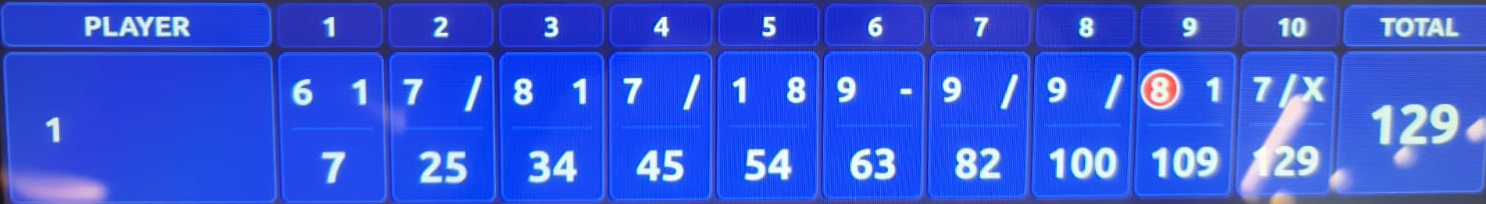

>>> RAW OCR TEXT
 647/7-8
1 129
725344554638210010925


>>> TOKENS  (len = 32 )
 ['6', '4', '7', '/', '7', '-', '8', '1', '1', '2', '9', '7', '2', '5', '3', '4', '4', '5', '5', '4', '6', '3', '8', '2', '1', '0', '0', '1', '0', '9', '2', '5']


In [28]:
debug_board(IMG_DIR/"20250612-game3.jpeg")   # to view tokens

In [13]:
# scoring sanity: make sure we produced 10 frames per board
bad_games = all(df_eval.groupby('game_id').frame.nunique() != 10)
if bad_games:
    print("[WARN] Some games had ≠ 10 frames; check OCR output.")

NameError: name 'df_eval' is not defined